# 10-armed testbed
## 여러 Agents에 대한 결과를 내주자.
## 이처럼 역할을 확실히 나눠서 하는 것도 괜찮긴 한데 좀 더 자유롭고 쉽게 구현하는 것은 아랫 부분이 더 나은 것 같다

In [ ]:
import numpy as np

class Testbed(object) : # 여기에서 state, action에 대한 정보를 갖는다.
    def __init__(self, K_arm, mean, std):
        self.K_arm = K_arm
        self.mean = mean
        self.std = std
        self.Actarr = np.zeros([K_arm])
        self.optim = 0
        self.reset()

    def reset(self):
        self.Actarr = np.random.normal(loc = self.mean, scale = self.std, size = self.K_arm) # action에 대한 reward 분포의 mean (q*(a))
        self.optim = np.argmax(self.Actarr)

class Agent(object) :
    def __init__(self, nArms, e_prob):
        self.nArms = nArms
        self.e_prob = e_prob
        self.lastAction = None

        self.time_step = 0
        self.K_action = np.zeros(nArms)
        self.rSum = np.zeros(nArms)
        self.valueEstimates = np.zeros(nArms)
        

    def action(self):
        rand_prob = np.random.random() # [0,1] random
        if self.e_prob >= rand_prob :
            a = np.random.choice(self.nArms)
        else :  # Greedy
            maxAction = np.argmax(self.valueEstimates)
            action = np.where(self.valueEstimates == self.valueEstimates[maxAction])[0]

            if len(action) == 0:
                a = action
            else :
                a = np.random.choice(action)
        self.lastAction = a
        return a

    def interpreter(self, reward):
        At = self.lastAction
        self.time_step += 1

        self.K_action[At] += 1
        self.rSum[At] += reward
        self.valueEstimates[At] = self.rSum[At]/self.K_action[At]
    #  다음 iter시를 위해 초기화
    def reset(self):
        self.lastAction = None
        self.time_step = 0
        
        self.K_action[:] = 0
        self.rSum[:] = 0
        self.valueEstimates[:] = 0


class Environment(object):
    def __init__(self, testbed, agents, plays, iterations): # 실행부
        self.testbed = testbed
        self.agents = agents
        self.plays = plays # timestep 길이.
        self.iterations = iterations

    def play(self):
        # Array to store the scores, number of plays X number of agents
        scoreArr = np.zeros((self.plays, len(self.agents)))
        # Array to maintain optimal count, Graph 2
        optimalArr = np.zeros((self.plays, len(self.agents)))

        for iter in range(self.iterations):
            if (iter + 1) % 100 == 0:
                print("Complete Iteration : {}".format(iter + 1))
            self.testbed.reset()
            for agent in agents :
                agent.reset()
            
            for this_play in range(self.plays):
                agtCnt = 0
                for KAgent in self.agents:
                    
                    Act = KAgent.action()
                    Reward = np.random.normal(self.testbed.Actarr[Act], 1.) # 현재 모델에서의 Reward 샘플링 되는 것.
                    KAgent.interpreter(Reward)

                    scoreArr[this_play, agtCnt] += Reward
                    
                    if Act == self.testbed.optim :
                        optimalArr[this_play, agtCnt] += 1 # 실제 optim 행동을 맞췄는가.

                    agtCnt += 1

        scoreAvg = scoreArr/self.iterations
        optimalAvg = optimalArr/self.iterations

        return scoreAvg, optimalAvg

In [ ]:

testbed = Testbed(10, 0, 1.)
agents = [Agent(10, 0),Agent(10, 0.1),Agent(10, 0.01)]
env = Environment(testbed ,agents, 1000, 2000)
print("Start ..")
scoreAvg, optimalAvg = env.play()

Start ..
Complete Iteration : 100
Complete Iteration : 200
Complete Iteration : 300
Complete Iteration : 400
Complete Iteration : 500
Complete Iteration : 600
Complete Iteration : 700
Complete Iteration : 800
Complete Iteration : 900
Complete Iteration : 1000
Complete Iteration : 1100
Complete Iteration : 1200
Complete Iteration : 1300
Complete Iteration : 1400
Complete Iteration : 1500
Complete Iteration : 1600
Complete Iteration : 1700
Complete Iteration : 1800
Complete Iteration : 1900
Complete Iteration : 2000


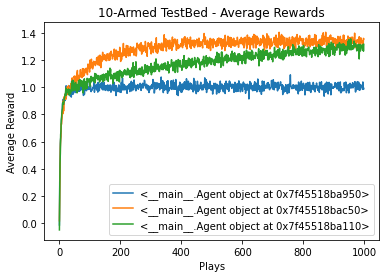

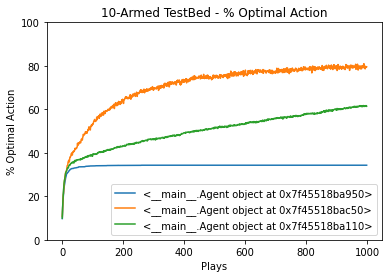

In [ ]:
import matplotlib.pyplot as plt

plt.title("10-Armed TestBed - Average Rewards")
plt.plot(scoreAvg)
plt.ylabel('Average Reward')
plt.xlabel('Plays')
plt.legend(agents, loc=4)
plt.show()

#Graph 1 - optimal selections over all plays
plt.title("10-Armed TestBed - % Optimal Action")
plt.plot(optimalAvg * 100)
plt.ylim(0, 100)
plt.ylabel('% Optimal Action')
plt.xlabel('Plays')
plt.legend(agents, loc=4)
plt.show()

In [10]:
import numpy as np
from tqdm.notebook import tqdm
"""
    <<Non Stationary>>

    epsilon : exploration
    average_sample : 표본평균 형식인지.
    initial_value : value estimate 경우
    gt_initial : q*(a) initial value
    step_size : alpha를 의미. (고정된 weight)


"""

class GreedyEpsilon(object):
    def __init__(self, n_arms, epsilon, average_sample, initial_value, gt_initial, step_size=0):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.average_sample = average_sample
        self.initial_value = initial_value
        self.gt_initial = gt_initial
        self.step_size = step_size
        self.times = 0

    def reset(self):
        self.q_star = np.zeros(self.n_arms) + self.gt_initial
        self.estimator = np.zeros(self.n_arms) + self.initial_value
        self.Act_num = np.zeros(self.n_arms)
        self.optimal_action = np.argmax(self.q_star)


    def act(self): # 액션
        ran = np.random.random()
        if ran < self.epsilon :
            return np.random.choice(self.n_arms)
        else :
            max_val = np.max(self.estimator)
            return np.random.choice([i for i,k in enumerate(self.estimator) if k == max_val])

    def step(self, action):
        self.times += 1
        reward = self.q_star[action] + np.random.randn()

        self.Act_num[action] += 1
        self.q_star += np.random.randn(self.n_arms) * 0.01 # Non Stationary

        if self.average_sample :
            self.estimator[action] += (1./self.Act_num[action])*(reward - self.estimator[action])
        else :
            self.estimator[action] += self.step_size*(reward - self.estimator[action])
        
        return reward


class UCB(object):
    def __init__(self, n_arms, average_sample, initial_value, gt_initial, step_size=0, c= 2.0):
        self.n_arms = n_arms

        self.average_sample = average_sample
        self.initial_value = initial_value
        self.gt_initial = gt_initial
        self.step_size = step_size
        self.times = 0
        self.c = c

    def reset(self):
        self.q_star = np.zeros(self.n_arms) + self.gt_initial
        self.estimator = np.zeros(self.n_arms) + self.initial_value
        self.Act_num = np.zeros(self.n_arms)
        self.optimal_action = np.argmax(self.q_star)


    def act(self): # 액션

        ran = np.random.random()
        temp = [act_est + self.c*(np.sqrt(np.log(self.times+1)/(act_num+1e-10))) for act_est, act_num in zip(self.estimator, self.Act_num)]
        max_val = np.max(temp)
        actions = [i for i,v in enumerate(temp) if v == max_val]
        return np.random.choice(actions)

    def step(self, action):
        self.times += 1
        reward = self.q_star[action] + np.random.randn()

        self.Act_num[action] += 1
        self.q_star += np.random.randn(self.n_arms) * 0.01 # Non Stationary

        if self.average_sample :
            self.estimator[action] += (1./self.Act_num[action])*(reward - self.estimator[action])
        else :
            self.estimator[action] += self.step_size*(reward - self.estimator[action])
        
        return reward

class GradientBandit(object):
    def __init__(self,n_arms, alpha, gt_initial, is_baseline=True):
        self.n_arms = n_arms
        self.alpha = alpha
        self.gt_initial = gt_initial
        self.is_baseline = is_baseline
        self.times = 0
        

    def reset(self):
        self.preference = np.zeros(self.n_arms)
        self.q_star = np.zeros(self.n_arms)
        self.average_reward = 0
        self.optimal_action = np.argmax(self.q_star)

    def act(self):
        softmax_unnormalized = np.exp(self.preference)
        self.softmax = softmax_unnormalized / sum(softmax_unnormalized)

        return np.random.choice(range(self.n_arms), p=self.softmax)

    def step(self, action):
        reward = self.q_star[action] + np.random.randn()
        self.times += 1

        self.q_star += np.random.randn(self.n_arms)*0.01
        self.average_reward += 1.0 / self.times * (reward - self.average_reward)

        if self.is_baseline :
            mean_reward = self.average_reward
        else :
            mean_reward = 0

        one_hot = np.zeros(self.n_arms)
        one_hot[action] = 1
        
        self.preference += self.alpha*(reward - mean_reward)*(one_hot-self.softmax)
        return reward

def simulate( bandits, iteration, plays ):
    optimal_act = np.zeros([len(bandits), iteration, plays])
    rewards_list = np.zeros([len(bandits), iteration, plays])
    for i, bandit in enumerate(bandits) :

        for iter in tqdm(range(iteration)):
            bandit.reset()
            for play in range(plays):
                action = bandit.act()
                reward = bandit.step(action)

                rewards_list[i, iter, play] = reward

                if action == bandit.optimal_action:
                    optimal_act[i, iter, play] = 1
    
    rewards = np.mean(rewards_list, axis =1)
    optimal_act = np.mean(optimal_act, axis =1)
    return rewards ,optimal_act



# Practice 2.5
## 점증적 구현과 기하급수적 최신 가중 평균

In [ ]:
bandits = [
           GreedyEpsilon(n_arms= 10, epsilon =0.1, average_sample=True, initial_value=0., gt_initial=0., step_size=0),
           GreedyEpsilon(n_arms= 10, epsilon =0.1, average_sample=False, initial_value=0., gt_initial=0., step_size=0.1)
           ]


rewards, optimal_act = simulate(bandits, 2000, 10000)

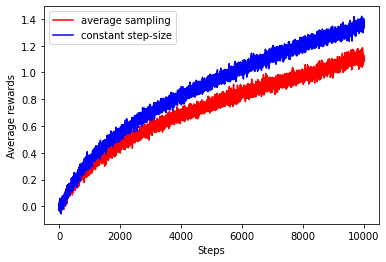

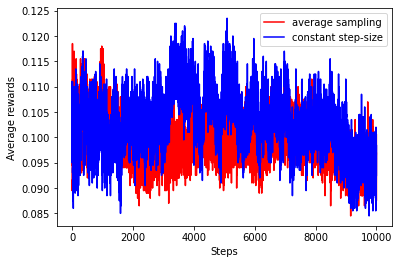

In [ ]:
import matplotlib.pyplot as plt

label = ['average sampling', 'constant step-size']
color = ['r', 'b']
for r,l,c in zip(rewards,label,color):
    plt.plot(r, label=l, color=c)
plt.xlabel('Steps')
plt.ylabel('Average rewards')
plt.legend()

plt.show()


label = ['average sampling', 'constant step-size']
color = ['r', 'b']

for r,l,c in zip(optimal_act,label,color):
    plt.plot(r, label=l, color=c)
plt.xlabel('Steps')
plt.ylabel('Average rewards')
plt.legend()

plt.show()

# Practice 2.10

In [16]:
"""
    parameters : 
    greedy_1 : 1/128, 1/64, 1/32, 1/16, 1/8, 1/4
    greedy_2 : 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, alpha : 0.1 
    GradientBandit : 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4
    UCB : 1/16, 1/8, 1/4, 1/2, 1, 2, 4
    unstationary_positive_start : 1/4, 1/2, 1, 2, 4
"""

bandits_name = ["greedy_1", "greedy_2", "GradientBandit", "UCB", "unstationary_positive_start"]

parameters = {"greedy_1" :np.arange(-7,-1,dtype=float),
              "greedy_2" :np.arange(-7,-1,dtype=float),
              "GradientBandit" :np.arange(-5,3,dtype=float),
              "UCB" :np.arange(-4,3,dtype=float),
              "unstationary_positive_start" :np.arange(-2, 3,dtype=float)}

greedy_1 = [GreedyEpsilon(n_arms= 10, epsilon =np.power(2, epsilon), average_sample=True, initial_value=0., gt_initial=0., step_size=0) for epsilon in parameters['greedy_1']]
greedy_2 = [GreedyEpsilon(n_arms= 10, epsilon =np.power(2, epsilon), average_sample=False, initial_value=0., gt_initial=0., step_size=0.1) for epsilon in parameters['greedy_2']]
gradient = [GradientBandit(n_arms=10, alpha = np.power(2, alpha), gt_initial=0., is_baseline=True) for alpha in parameters['GradientBandit']]
ucb = [UCB(n_arms=10, average_sample=True, initial_value=0, gt_initial=0, step_size=0, c= np.power(2, c)) for c in parameters['UCB']]
positive = [GreedyEpsilon(n_arms= 10, epsilon =0, average_sample=False, initial_value=np.power(2, initial_value), gt_initial=0., step_size=0.1) for initial_value in parameters['unstationary_positive_start']]

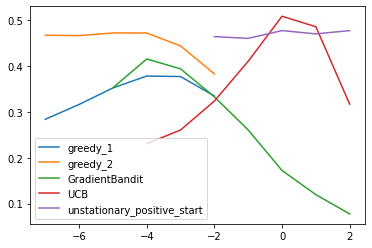

In [24]:
import matplotlib.pyplot as plt

all_bandits_rewards = []

for i, bandits in enumerate([greedy_1, greedy_2, gradient, ucb, positive]):
    print("This bandit is : {}".format(bandits_name[i]))
    this_bandits_rewards, _ = simulate(bandits, 2000, 2000)
    all_bandits_rewards.append(this_bandits_rewards)


for i,bandits_rewards in enumerate(all_bandits_rewards) :
    performance_matrix = bandits_rewards[:,1000:]
    performance = np.mean(performance_matrix, axis = -1)
    plt.plot(parameters[bandits_name[i]],performance)
plt.legend(bandits_name)

plt.show()